# Model Analysis
____

In this notebook, I will be analysis the the two models that were trained in the Modeling.ipynb notebook and how they score on the 24 diffrent classes that can be shown in an image

In [2]:
import os
# Change working directory up one folder to use custom modules
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import cv2


from glob import glob


from module.u_net_model import unet_model
from module.data_load import *

2023-06-11 15:56:35.922726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading Data

I will load in the preprocessed data set that had resized the images and masks

In [34]:
img_folder = './semantic_drone_dataset/processed/images/'
mask_folder = './semantic_drone_dataset/processed/label_images/'

img_files = np.sort(os.listdir(img_folder))
mask_files = np.sort(os.listdir(mask_folder))

images = create_image_array(img_folder, img_files)
masks = create_image_array(mask_folder, mask_files)

In [57]:
def mask_shape(masks):
    new_masks = []
    for mask in masks:
        new_mask = np.reshape(mask[:, :, 0], (224, 224, 1))
        new_masks.append(new_mask)
    return new_masks

true_masks = mask_shape(masks)

In [52]:
# Convert the mask values into RGB values for plotting
masks_rgb = list(map(mask_rgb, masks))

In [5]:
# Creating both models and loading the best weights from training
model_dice = unet_model(24)
model_dice.load_weights('./models/seg_model_dice.h5')

model_cc = unet_model(24)
model_cc.load_weights('./models/seg_model_cc.h5')

### Predictions

Each model will be used to make a prediciton on the images in the dataset. I will create a list for each of the predicted mask and the predicted masks with RGB for plotting.

In [6]:
# Lists for Dice Loss Model predictions
dice_preds = []
dice_preds_rgb = []
for img in images:
    pred = model_dice.predict(img[tf.newaxis, ...], verbose = 0)
    pred = mask_decoding(pred)[0]
    pred_rgb = mask_rgb(pred)
    dice_preds.append(pred)
    dice_preds_rgb.append(pred_rgb)

In [7]:
# Lists for CrossCategorical Entropy Loss Model predictions
cc_preds = []
cc_preds_rgb = []
for img in images:
    pred = model_cc.predict(img[tf.newaxis, ...], verbose = 0)
    pred = mask_decoding(pred)[0]
    pred_rgb = mask_rgb(pred)
    cc_preds.append(pred)
    cc_preds_rgb.append(pred_rgb)

To be able to check images that correspond to low or high scores in the predictions, I will create 2 sets of lists that contain the images and masks and predictions from each model. This will also include RGB versions of masks and predictions. 

In [58]:
series = []
for i in range(len(images)):
    series.append([images[i], true_masks[i], dice_preds[i], cc_preds[i]])
    
series_rgb = []
for i in range(len(images)):
    series_rgb.append([images[i], masks_rgb[i], dice_preds_rgb[i], cc_preds_rgb[i]])

In [9]:
# Read class name corresponding to label
class_names = list(pd.read_csv('./semantic_drone_dataset/class_dict.csv')['name'])

In [59]:
def create_pred_df(model_num=2):
    class_iou = {}
    for i in range(24):
        column = class_names[i]
        class_iou[column] =  []
        iou = tf.keras.metrics.IoU(num_classes=24, target_class_ids=[i])
        for j in range(len(series)):
            iou.update_state(series[j][1], series[j][model_num])
            class_iou[column].append( iou.result().numpy() )
            iou.reset_state()
    df = pd.DataFrame(class_iou)
    return df

### IoU Scoring

For scoring of the models, I will evaluate the average IoU score for each class in the data, while only including non-zero values in the average because that class could've been absent in the image

In [60]:
# Create IoU score dataframes
dice_iou_df = create_pred_df(2)
cc_iou_df = create_pred_df(3)

In [61]:
# Select columns that are relevant for task
interest_columns = ['paved-area', 'dirt', 'grass', 'gravel']

In [74]:
def score_avg(df):
    """
    Calculate average IoU score while filtering for zero-values in each category
    """
    scores = {}
    for column in df.columns:
        avg = df[df[column] > 0][column].mean()
        scores[column] = [avg]
    return pd.DataFrame(scores)

In [102]:
dice_avg_iou = score_avg(dice_iou_df[interest_columns])
dice_avg_iou = dice_avg_iou.T
dice_avg_iou.columns = ['Dice']

In [103]:
cc_avg_iou = score_avg(cc_iou_df[interest_columns])
cc_avg_iou = cc_avg_iou.T
cc_avg_iou.columns = ['CCE']

In [115]:
# join dataframes for easier plotting
joint = pd.merge(dice_avg_iou, cc_avg_iou, how='left', left_index=True, right_index=True)
joint.reset_index(inplace=True)
joint.rename(columns = {'index':'Class'}, inplace=True)

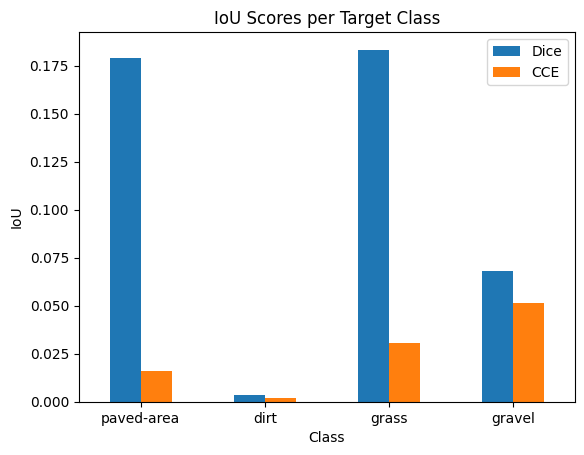

In [129]:
fig, ax = plt.subplots()
joint.plot.bar(x='Class', ax=ax,rot=0)
plt.title('IoU Scores per Target Class')
plt.ylabel('IoU')
fig.savefig('./imgs/pred_iou_scores.png')

While the training curves during modeling showed the Entropy was a better performing loss function, the dice coefficient performed better in the target categories. 

In [82]:
# Average IoU score for all classes in dataset
cc_full_avg_iou = score_avg(cc_iou_df)
cc_full_avg_iou.T.sort_values(by=0, ascending = False)

,0
unlabeled,0.491206
pool,0.085057
ar-marker,0.075685
roof,0.060314
gravel,0.051300
obstacle,0.041094
vegetation,0.039944
wall,0.037976
window,0.037650
grass,0.030559


In [124]:
# Average IoU score for all classes in dataset
dice_full_avg_iou = score_avg(dice_iou_df)
dice_full_avg_iou.T.sort_values(by=0, ascending = False)

,0
unlabeled,0.361291
grass,0.183297
paved-area,0.178900
ar-marker,0.115425
vegetation,0.115274
roof,0.069760
gravel,0.067878
wall,0.059291
obstacle,0.050775
person,0.043463
